In [22]:
from cobra.io import read_sbml_model, write_sbml_model
from cobra import Reaction, Metabolite
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
model = read_sbml_model('data/iML1515_het.xml')

# All genes single KO:

In [3]:
higher_production_KO = {}
lower_production_KO = {}

# We set a limit for Biomass to drop: 80% of max Biomass production
# This is very important because since production P3HB has a tradeoff with Biomass production, not setting this 
# 80% biomass lower limit would cause the model to produce NO Biomass to maximize the production of P3HB. 
max_growth = model.optimize().objective_value
min_growth = 0.8 * max_growth  
max_growth = 1.0 * max_growth  
model.reactions.get_by_id("BIOMASS_Ec_iML1515_core_75p37M").bounds = min_growth, max_growth

with model:
    # We optimize for P3HB production:
    r_phaC_exp = model.add_boundary(model.metabolites.get_by_id('P3HB_c'), type='sink')
    model.objective = r_phaC_exp
    Basal_P3HB_production = model.optimize().objective_value
    print('Basal P3HB production: ', Basal_P3HB_production)

    # Now we iterate through every gene and perform a single KO and recheck P3HB production:
    for gene in model.genes:
        
        with model:
        
            gene.knock_out()
            KO_P3HB_production = model.slim_optimize(error_value=0.)
            
            # We keep those genes whose KO increases P3HB production in a dictionary containing the gene ID and the P3HB production
            if KO_P3HB_production > Basal_P3HB_production:
                higher_production_KO[gene.id] = KO_P3HB_production
            else:
                lower_production_KO[gene.id] = KO_P3HB_production

# We sort the dictionary with descending P3HB production values:                
sorted_items = sorted(higher_production_KO.items(), key=lambda x: x[1], reverse=True)
higher_production_KO_sorted = dict(sorted_items)

# We transform production values into percentages of produciton increase:
for key in higher_production_KO_sorted:
    higher_production_KO_sorted[key] /= Basal_P3HB_production*100

# We show Top 5 performing KO genes:
print('Top 5 genes whose KO causes p3HB production increase:')
for key, value in list(higher_production_KO_sorted.items())[:5]:
    print(f'{model.genes.get_by_id(key).name} ({key}): {round(value, 6)}%')

KO_hemL = higher_production_KO_sorted['b0154']
KO_ubiD = higher_production_KO_sorted['b3843']
KO_ispB = higher_production_KO_sorted['b3187']
KO_ubiA = higher_production_KO_sorted['b4040']
KO_cysG = higher_production_KO_sorted['b3368']

Basal P3HB production:  2.7428235294114476
Top 5 genes whose KO causes p3HB production increase:
hemL (b0154): 0.010012%
ubiD (b3843): 0.010009%
ispB (b3187): 0.010009%
ubiA (b4040): 0.010009%
cysG (b3368): 0.010007%


## Overview of the best performing genes:

### hemL:

In [4]:
model.genes.b0154

Gene identifier,b0154
Name,hemL
Memory address,0x2b0a20078d0
Functional,True
In 1 reaction(s),G1SAT


In [5]:
model.reactions.G1SAT

Reaction identifier,G1SAT
Name,Glutamate-1-semialdehyde aminotransferase
Memory address,0x2b0a243dc50
Stoichiometry,glu1sa_c <=> 5aop_c L-Glutamate 1-semialdehyde <=> 5-Amino-4-oxopentanoate
GPR,b0154
Lower bound,-1000.0
Upper bound,1000.0


Encodes glutamate 1-semialdehyde aminotransferase and is involved in the Porphyrin-containing compound metabolism P23893 (UniProt).

### ubiD:

In [6]:
model.genes.b3843

Gene identifier,b3843
Name,ubiD
Memory address,0x2b0a1f4bd90
Functional,True
In 1 reaction(s),OPHBDC


In [7]:
model.reactions.OPHBDC

Reaction identifier,OPHBDC
Name,Octaprenyl-hydroxybenzoate decarboxylase
Memory address,0x2b0a2588d90
Stoichiometry,3ophb_c + h_c --> 2oph_c + co2_c 3-Octaprenyl-4-hydroxybenzoate + H+ --> 2-Octaprenylphenol + CO2 CO2
GPR,b3843
Lower bound,0.0
Upper bound,1000.0


Encondes for Octaprenyl-hydroxybenzoate decarboxylase and is involved in Ubiquinone biosynthesis. P0AAB4 (UniProt)

### ispB:

In [8]:
model.genes.b3187

Gene identifier,b3187
Name,ispB
Memory address,0x2b0a1f81cd0
Functional,True
In 1 reaction(s),OCTDPS


In [9]:
model.reactions.OCTDPS

Reaction identifier,OCTDPS
Name,Octaprenyl pyrophosphate synthase
Memory address,0x2b0a2666090
Stoichiometry,frdp_c + 5.0 ipdp_c --> octdp_c + 5.0 ppi_c Farnesyl diphosphate + 5.0 Isopentenyl diphosphate --> All-trans-Octaprenyl diphosphate + 5.0 Diphosphate
GPR,b3187
Lower bound,0.0
Upper bound,1000.0


Supplies octaprenyl diphosphate, the precursor for the side chain of the isoprenoid quinones ubiquinone and menaquinone. P0AD57 (UniProt)

### ubiA:

In [10]:
model.genes.b4040

Gene identifier,b4040
Name,ubiA
Memory address,0x2b0a1fde810
Functional,True
In 1 reaction(s),HBZOPT


In [11]:
model.reactions.HBZOPT

Reaction identifier,HBZOPT
Name,Hydroxybenzoate octaprenyltransferase
Memory address,0x2b0a2659bd0
Stoichiometry,4hbz_c + octdp_c --> 3ophb_c + ppi_c 4-Hydroxybenzoate + All-trans-Octaprenyl diphosphate --> 3-Octaprenyl-4-hydroxybenzoate + Diphosphate
GPR,b4040
Lower bound,0.0
Upper bound,1000.0


Mediates the second step in the final reaction sequence of ubiquinone-8 (UQ-8) biosynthesis. P0AGK1 (UniProt)

### cysG:

In [12]:
model.genes.b3368

Gene identifier,b3368
Name,cysG
Memory address,0x2b0a1f55090
Functional,True
In 3 reaction(s),"SHCHF, SHCHD2, UPP3MT"


In [13]:
model.reactions.SHCHD2
model.reactions.SHCHF
model.reactions.UPP3MT

Reaction identifier,UPP3MT
Name,Uroporphyrinogen methyltransferase
Memory address,0x2b0a32fb210
Stoichiometry,2.0 amet_c + uppg3_c --> 2.0 ahcys_c + dscl_c + h_c 2.0 S-Adenosyl-L-methionine + Uroporphyrinogen III --> 2.0 S-Adenosyl-L-homocysteine + Dihydrosirohydrochlorin + H+
GPR,b3368
Lower bound,0.0
Upper bound,1000.0


Involved in the following pathways:
- Cofactor biosynthesis; adenosylcobalamin biosynthesis; precorrin-2 from uroporphyrinogen III.
- Cofactor biosynthesis; adenosylcobalamin biosynthesis; sirohydrochlorin from precorrin-2.
- Porphyrin-containing compound metabolism; siroheme biosynthesis; precorrin-2 from uroporphyrinogen III.
- Porphyrin-containing compound metabolism; siroheme biosynthesis; siroheme from sirohydrochlorin.
- Porphyrin-containing compound metabolism; siroheme biosynthesis; sirohydrochlorin from precorrin-2.

### Conclussion:
What we can see from the most influent KO genes from the analysis is:
- The Top 5 are involved in cofactor metabolism.
- Top 2 to 4 is involved in ubiquinone metabolism.
- Top 1 and Top 5 is involved in porphyrin metabolism.

# KO Combinations:

## Ubiquinone genes KO (ubiD, ispB, ubiA):
- ubiD (b3843): 0.010009%
- ispB (b3187): 0.010009%
- ubiA (b4040): 0.010009%

In [16]:
with model:
    
    # We optimize for P3HB production:
    r_phaC_exp = model.add_boundary(model.metabolites.get_by_id('P3HB_c'), type='sink')
    model.objective = r_phaC_exp
    Basal_P3HB_production = model.optimize().objective_value
    print('Basal P3HB production: ', round(Basal_P3HB_production, 5))
    
    # we KO the 3 genes at the same time:
    model.genes.b3843.knock_out()    # ubiD
    model.genes.b3187.knock_out()    # ispB
    model.genes.b4040.knock_out()    # ubiA
    KO_P3HB_production = model.optimize().objective_value
    print('KO P3HB production: ', round(KO_P3HB_production, 5))


# We show Top 5 performing KO genes:
print('ubiD, ispB and ubiA KO generates a P3HB flux increase of:')
print(round((KO_P3HB_production-Basal_P3HB_production)/Basal_P3HB_production*100, 5), "%")
KO_ubiquinone_genes = (KO_P3HB_production-Basal_P3HB_production)/Basal_P3HB_production*100


Basal P3HB production:  2.74282
KO P3HB production:  2.74538
ubiD, ispB and ubiA KO generates a P3HB flux increase of:
0.09311 %


We see the effect of the 3 combined KO is not additive, but rather bigger than that. 

## Porphirin genes KO (hemL, cysG)

- hemL (b0154): 0.010012%
- cysG (b3368): 0.010007%

In [17]:
with model:
    
    # We optimize for P3HB production:
    r_phaC_exp = model.add_boundary(model.metabolites.get_by_id('P3HB_c'), type='sink')
    model.objective = r_phaC_exp
    Basal_P3HB_production = model.optimize().objective_value
    print('Basal P3HB production: ', round(Basal_P3HB_production, 5))
    
    # we KO the 2 genes at the same time:
    model.genes.b0154.knock_out()    # hemL
    model.genes.b3368.knock_out()    # cysG
    KO_P3HB_production = model.slim_optimize()
    print('KO P3HB production: ', round(KO_P3HB_production, 5))


# We show Top 5 performing KO genes:
print('hemL and cysG KO generates a P3HB flux increase of:')
print(round((KO_P3HB_production-Basal_P3HB_production)/Basal_P3HB_production*100, 5), "%")
KO_porphirin_genes = (KO_P3HB_production-Basal_P3HB_production)/Basal_P3HB_production*100

Basal P3HB production:  2.74282
KO P3HB production:  nan
hemL and cysG KO generates a P3HB flux increase of:
nan %


## Ubiquinone and hemL KO (ubiD, ispB, ubiA, hemL):

In [18]:
with model:
    
    # We optimize for P3HB production:
    r_phaC_exp = model.add_boundary(model.metabolites.get_by_id('P3HB_c'), type='sink')
    model.objective = r_phaC_exp
    Basal_P3HB_production = model.optimize().objective_value
    print('Basal P3HB production: ', round(Basal_P3HB_production, 5))
    
    # we KO the 3 genes at the same time:
    model.genes.b3843.knock_out()    # ubiD
    model.genes.b3187.knock_out()    # ispB
    model.genes.b4040.knock_out()    # ubiA
    model.genes.b0154.knock_out()    # hemL
    KO_P3HB_production = model.optimize().objective_value
    print('KO P3HB production: ', round(KO_P3HB_production, 5))


# We show Top 5 performing KO genes:
print('ubiD, ispB and ubiA KO generates a P3HB flux increase of:')
print(round((KO_P3HB_production-Basal_P3HB_production)/Basal_P3HB_production*100, 5), "%")
KO_ubiquinone_hemL_genes = (KO_P3HB_production-Basal_P3HB_production)/Basal_P3HB_production*100

Basal P3HB production:  2.74282
KO P3HB production:  2.74879
ubiD, ispB and ubiA KO generates a P3HB flux increase of:
0.2176 %


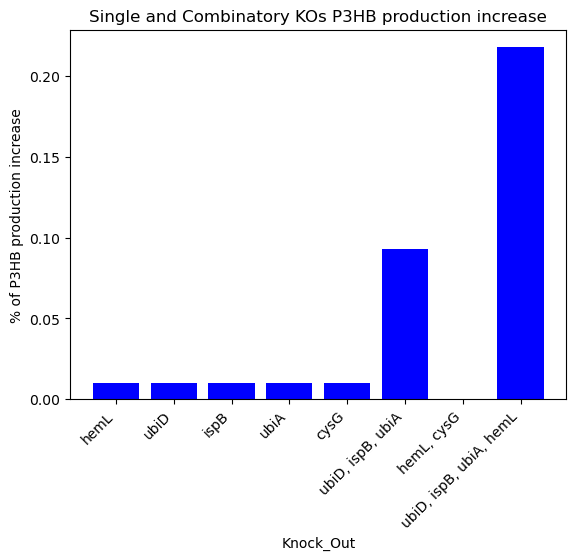

In [21]:
# Example data
KOs = ['hemL', 'ubiD', 'ispB', 'ubiA', 'cysG', 'ubiD, ispB, ubiA', 'hemL, cysG', 'ubiD, ispB, ubiA, hemL']
values = [KO_hemL, KO_ubiD, KO_ispB, KO_ubiA, KO_cysG, KO_ubiquinone_genes, KO_porphirin_genes, KO_ubiquinone_hemL_genes]

# Create a bar plot
plt.bar(KOs, values, color='blue')
plt.xticks(rotation=45, ha='right')

plt.xlabel('Knock_Out')
plt.ylabel('% of P3HB production increase')
plt.title('Single and Combinatory KOs P3HB production increase')
plt.show()

As we can see, little by little we manage to increase production. Although it seems marginal for the amount of laboratory work that this would suppose. 

The production increase is by no means liniar < f.e. P3HB(2KO) != 2xP3HB(1KO) > or additive < f.e.  P3HB(ubiD, ispB, ubiA, hemL) != P3HB(ubiD, ispB, ubiA) + P3HB(hemL) >. This suggests that, if had been possible, running a combinatorial algorithm to try all possible KO combinations for 2, 3, 4 or 5 genes would have likely resulted in combinations with even higher effect on P3HB production.